# Project ML for portfolio management

⚠️ This notebook takes multiple hours to run from beginning to end, notably the dataset bulding function which takes between and 2 hours because of the webscrapping and API calls, as well as the 3rd section (Emprirical results) which takes multiple hours because of the grid search / multiple models being trained. ⚠️

In [ ]:
# ADDITIONAL PACKAGES (some may have already been installed but we need specific versions for compatibility reasons (ie pandas, numpy, ...))

%pip install pdfplumber
%pip install nbformat
%pip pandas==2.2.3
%pip install matplotlib==3.9.2
%pip install scipy==1.13.1
%pip install pyarrow==18.0.0
%pip install scikit-learn==1.5.2
%pip install statsmodels==0.14.4
%pip install seaborn
%pip install plotly
%pip install wordcloud
%pip install nltk
%pip install tf-keras
%pip install gensim
%pip install numpy==1.24.6
%pip install spacy

In [2]:
# MAIN IMPORTS
import requests
from bs4 import BeautifulSoup
import pandas as pd
import os
from pathlib import Path
import logging
import numpy as np 
import warnings
import pprint
from collections import Counter
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import pdfplumber  # For parsing PDF files
from io import BytesIO

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Suppress SettingWithCopyWarning
# pd.set_option('mode.chained_assignment', None)
# warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")

-----

### INTRODUCTION

Central bank speeches are a critical medium for conveying monetary policy intentions and market expectations, as well as communicating economic insights. The content and tone of these speeches can influence public perception and financial markets. However, limited research has been done to explore how these dynamics vary across gender, among central bank speakers. The aim of this project is to help fill this gap by investigating whether male and female central bank leaders differ in their communication styles using NLP techniques, focusing on the topics they address (topic modeling) and the tone of their speeches (sentiment analysis).

To conduct this analysis, we compiled a dataset of speeches delivered by central bank Governors and senior central bankers, published by the Bank for International Settlements. We filtered these speeches according to the institutions, keeping only those from European Central Banks. Using a combination of sentiment analysis and topic modeling, we systematically compared speech characteristics across genders.


Our findings suggest subtle differences in the tone and topics of speeches delivered by male and female central bank leaders. While sentiment analysis indicates that men exhibit slightly higher medians for both positive and negative sentiment scores, these differences are not pronounced. Moreover, few algorithms allow for sentiment analysis on large texts, and the few that do - Longformer for instance with a max input of 4096 tokens (versus 512 for most others) takes a very long time to run on our dataset, especially without a GPU (*I tried running it to compare /better our results but I didn't have the computational ressources necessary for the task*). \
Topic modeling reveals overlapping themes across genders, however, while male and female central bank leaders often address similar topics, there are some differences in the emphasis placed on certain themes
These results, while not groundbreaking, highlight the complexity of quantifying gendered communication styles in this domain and underscore the need for further research.

The inspiration for this project stems from the paper "Leadership, Gender, and Discourse in Monetary Policy: Analyzing Speech Dynamics in the FOMC" (https://papers.ssrn.com/sol3/papers.cfm?abstract_id=5002334). We applied similar methodologies to a novel dataset of European central bank speeches. Key resources include NLP libraries such as gensim, nltk and scikit-learn, as well as sentiment lexicons like Loughran-McDonald. The dataset of speeches and metadata was created through web scraping the BIS website, requesting the BIS API, and then enriched using the genderize.io API for speaker gender identification. \
Other reference that was used : Information in Central Bank Sentiment: An Analysis of Fed and ECB Communication (https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4797935).

---------

### DATASET OVERVIEW

The dataset is composed of all central bankers' speeches avilable on the BIS website, coming from european central banks institutions. The speeches date from 2009 up until 2024.
The data was requested through the BIS API and the speeches themselves were scrapped from the individual BIS speeches html pages. \
/!\ *the data collecting function takes a while to run as there are about 20000 speeches on the BIS website that are then filtered and scrapped* \
The *get_central_bank_speeches_urls* function requests all speeches individual urls and the *load_central_banks_speeches* requests all speeches metadata information and then scrapes the speeches content from the html pages if the filter of the institution correponds.\
The gender information is added through requesting the genderize.io API. (a mapping dictionary is also provided in case the API request doesn't go through)

--------

#### Build the dataset

In [3]:
def get_central_bank_speeches_urls():
    '''
    '''
    url = "https://www.bis.org/api/document_lists/cbspeeches.json"
    reviews=[]
    response = requests.get(url)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        speeches = response.json()
        # Get the list of speeches ids ,
        for review in speeches['list']:
            reviews.append(review)
    else:
        print(f"Failed to retrieve data. Status code: {response.status_code}")
    
    return(reviews)

review_urls = get_central_bank_speeches_urls()
print(f'There are a total of {len(review_urls)} central bank speeches available.')

There are a total of 20140 central bank speeches available.


In [4]:
logger = logging.getLogger(__name__)

def clean_directory_path(cache_dir, default_dir="data"):
    if cache_dir is None:
        cache_dir = Path(os.getcwd()) / default_dir
    if isinstance(cache_dir, str):
        cache_dir = Path(cache_dir)
    if not cache_dir.is_dir():
        os.makedirs(cache_dir)
    return cache_dir

In [5]:
def load_central_banks_speeches_pdf(cache_dir="data", force_reload=False, progress_bar=False, institutions_filter=[6]):
    """
    """
    filename = clean_directory_path(cache_dir) / "central_banks_speeches_pdf.parquet"
    # load from cache if it exists and not force_reload
    if (filename.exists()) and not force_reload:
        logger.info(f"loading from cache file: {filename}")
        speeches = pd.read_parquet(filename)
    else:
        logger.info("loading from external source")

        # get all speeches URLs
        urls = get_central_bank_speeches_urls()
        if progress_bar:
            review_urls_ = tqdm(urls)
        else:
            review_urls_ = urls

        # get speeches metadata + extract / scrape speech from html page
        all_speeches = []
        base_url_api = "https://www.bis.org/api/documents"
        base_url = "https://www.bis.org"

        # iterate over speeches URLs
        counter=0
        switch=None
        for link in review_urls_ : #tqdm(reviews):
            counter+=1
            speech_data = {}
            review_url = f'{base_url_api}{link}.json'
            # speech_url = f'{base_url}{link}.htm'
            speech_pdf = f'{base_url}{link}.pdf'
            print(f"Processing speech: {review_url}")

            try:
                # Fetch speech page
                review_response = requests.get(review_url)
                review_metadata = review_response.json()
                speech_data.update(review_metadata)

                # Check if 'institutions' exists, skip processing if not
                    # only scrape speech if it's the right institution (filtering before scraping)  
                if 'institutions' in speech_data and any(inst in speech_data['institutions'] for inst in institutions_filter) : #speech_data['institutions'] == institutions_filter :
                    switch = counter
                    try:

                        pdf_response = requests.get(speech_pdf) 
                        # Extract text from the PDF
                        with pdfplumber.open(BytesIO(pdf_response.content)) as pdf:
                            pdf_text = ''.join(page.extract_text() for page in pdf.pages)
                            speech_data['speech_content'] = pdf_text
                    
                        # append speech dict (content + metadata) to all_speeches
                        all_speeches.append(speech_data)

                    except Exception as e:
                        print(f"Failed to process speech: {speech_pdf}, error: {e}")
                        continue 

                else:
                    print(f"Skipping speech {review_url}: Institution not in filter or wrong institution")

            except Exception as e:
                    print(f"Failed to fetch data of review {review_url}, status code: {review_response.status_code}")
                    continue 
        
        # Convert to DataFrame
        speeches = pd.DataFrame(all_speeches)
        
        # Save to cache
        logger.info(f"saving cache file {filename}")
        speeches.to_parquet(filename)
    return speeches

In [6]:
speeches = load_central_banks_speeches_pdf(force_reload=False, progress_bar=True) # 113m39 = 2h
speeches.head(5)

,id,path,menu_id,short_title,long_title,publication_start_date,language,pdf_file_size,pdf_pages,has_content,format,sources,authors,recurse_category,institutions,speech_content,topics,abstract
0,6657,/review/r090217b.pdf,256,Jean-Claude Trichet: Ten years of the euro - s...,"Speech by Mr Jean-Claude Trichet, President of...",2009-02-17T11:05:00.000+01:00,en,53,8,False,HTML_abstract,[Central bank],"[{'author_type': 1, 'id': 241, 'name': 'Jean-C...",[Speeches],[6],Jean-Claude Trichet: Ten years of the euro – s...,None,None
1,6660,/review/r090217e.pdf,256,Lucas Papademos: Tackling the financial crisis...,"Speech by Mr Lucas Papademos, Vice President o...",2009-02-17T11:05:00.000+01:00,en,55,8,False,HTML_abstract,[Central bank],"[{'author_type': 1, 'id': 253, 'name': 'Lucas ...",[Speeches],[6],Lucas Papademos: Tackling the financial crisis...,None,None
2,6661,/review/r090218a.pdf,256,"Jean-Claude Trichet: Macroeconomic policies, i...","Address by Mr Jean-Claude Trichet, President o...",2009-02-18T11:05:00.000+01:00,en,29,3,False,HTML_abstract,[Central bank],"[{'author_type': 1, 'id': 241, 'name': 'Jean-C...",[Speeches],[6],"Jean-Claude Trichet: Macroeconomic policies, i...",None,None
3,6665,/review/r090218e.pdf,256,Lorenzo Bini Smaghi: Regulation and supervisor...,"Speech by Mr Lorenzo Bini Smaghi, Member of th...",2009-02-18T11:05:00.000+01:00,en,37,6,False,HTML_abstract,[Central bank],"[{'author_type': 1, 'id': 254, 'name': 'Lorenz...",[Speeches],[6],Lorenzo Bini Smaghi: Regulation and supervisor...,None,None
4,6666,/review/r090219a.pdf,256,Jean-Claude Trichet: Interview with China Finance,"Interview by Mr Jean-Claude Trichet, President...",2009-02-19T11:05:00.000+01:00,en,20,3,False,HTML_abstract,[Central bank],"[{'author_type': 1, 'id': 241, 'name': 'Jean-C...",[Speeches],[6],Jean-Claude Trichet: Interview with China Fina...,None,None


- Check for and delete unproperly downloaded PDF content, because of encoding mismatch (text scrapped contains 'cid')

In [7]:
# find all '(cid:XX)' patterns in text
def find_cid_patterns(text):
    # Regex to match '(cid:XX)' where XX are digits
    pattern = r'\(cid:\d+\)'
    return re.findall(pattern, text)

speeches['cid_patterns'] = speeches['speech_content'].apply(find_cid_patterns)
# Filter speeches containing 'cid' patterns
cid_speeches = speeches[speeches['cid_patterns'].str.len() > 0]
speeches = speeches[speeches['cid_patterns'].str.len() <= 0]
print(f'Number of unproperly scrapped speeches: {len(cid_speeches)}')

Number of unproperly scrapped speeches: 108


In [8]:
# Check for empty or null strings, where we weren't able to retrieve the PDF content automatically
len(speeches[speeches['speech_content'].str.strip() == ""])
empty_speeches = speeches[speeches['speech_content'].str.strip() == ""]
print(f"Number of empty speeches: {len(empty_speeches)}")
speeches = speeches[speeches['speech_content'].str.strip() != ""]

Number of empty speeches: 6


In [9]:
print(f"The dataset contains {len(speeches)} speeches in total.")
speeches.columns

The dataset contains 1866 speeches in total.


Index(['id', 'path', 'menu_id', 'short_title', 'long_title',
       'publication_start_date', 'language', 'pdf_file_size', 'pdf_pages',
       'has_content', 'format', 'sources', 'authors', 'recurse_category',
       'institutions', 'speech_content', 'topics', 'abstract', 'cid_patterns'],
      dtype='object')

- Extract speaker names + map their gender 

In [10]:
def process_authors(authors_array):
    if isinstance(authors_array, np.ndarray):
        authors_list = authors_array.tolist()
        for author in authors_list:
            if 'name' in author and author['name'] == 'Benoît C&#339;uré': # Replace all occurrences of 'Benoît C&#339;uré' with 'Coeuré'
                author['name'] = 'Benoît Coeuré'
        return authors_list
    return authors_array

In [11]:
speeches['authors'] = speeches['authors'].apply(process_authors)
speeches['speaker_name'] = speeches['authors'].apply(lambda authors: authors[0]['name'] if authors else None) # Extract primary speaker name

# Get the count of each name
name_counts = Counter(speeches['speaker_name'])

# get unique names :
all_names = set(speeches['speaker_name'])
print("All Author Names:", all_names)
print("Name Counts:")
pprint.pp(name_counts)

All Author Names: {'Jürgen Stark', 'Patrick Montagner', 'Claudia Buch', 'Frank Elderson', 'Jean-Claude Trichet', 'Elizabeth McCaul', 'Mario Draghi', 'Vítor Constâncio', 'Linah K Mohohlo', 'José Manuel González-Páramo', 'Lucas Papademos', 'Gertrude Tumpel-Gugerell', 'Peter Praet', 'Isabel Schnabel', 'Fabio Panetta', 'Piero Cipollone', 'Luis de Guindos', 'Benoît Coeuré', 'Lorenzo Bini Smaghi', 'Andrew G Haldane', 'Jörg Asmussen', 'Joseph Yam', 'Yves Mersch', 'Philip R Lane', 'Sabine Lautenschläger', 'Sarah Bloom Raskin', 'Christine Lagarde'}
Name Counts:
Counter({'Mario Draghi': 277,
         'Benoît Coeuré': 253,
         'Jean-Claude Trichet': 177,
         'Yves Mersch': 157,
         'Peter Praet': 144,
         'Christine Lagarde': 140,
         'Vítor Constâncio': 121,
         'Luis de Guindos': 98,
         'Sabine Lautenschläger': 94,
         'Lorenzo Bini Smaghi': 56,
         'Fabio Panetta': 51,
         'Philip R Lane': 48,
         'Isabel Schnabel': 45,
         'Jörg Asm

In [12]:
# with genderize.io API 

def fetch_gender(name) :
    """
    Use Genderize.io to fetch gender for a given name.
    """
    url = f"https://api.genderize.io"
    params = {"name": name}
    
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()  # Raise an error for bad HTTP responses
        gender_data = response.json()
        return gender_data.get("gender"), gender_data.get("probability")
    except requests.exceptions.RequestException as e:
        print(f"Error fetching gender for {name}: {e}")
        return None, None

fetched_genders = {}
for name in all_names :
    fetched_genders[name] = fetch_gender(name)

pprint.pp(fetched_genders)

speeches[['gender', 'confidence']] = speeches['speaker_name'].map(fetched_genders).apply(pd.Series)
speeches.head(3)

{'Jürgen Stark': ('male', 1.0),
 'Patrick Montagner': ('male', 1.0),
 'Claudia Buch': ('female', 0.99),
 'Frank Elderson': ('male', 1.0),
 'Jean-Claude Trichet': ('male', 1.0),
 'Elizabeth McCaul': ('female', 1.0),
 'Mario Draghi': ('male', 0.99),
 'Vítor Constâncio': ('male', 1.0),
 'Linah K Mohohlo': ('female', 0.98),
 'José Manuel González-Páramo': ('male', 0.98),
 'Lucas Papademos': ('male', 0.99),
 'Gertrude Tumpel-Gugerell': ('female', 0.98),
 'Peter Praet': ('male', 1.0),
 'Isabel Schnabel': ('female', 0.99),
 'Fabio Panetta': ('male', 1.0),
 'Piero Cipollone': ('male', 0.99),
 'Luis de Guindos': ('male', 1.0),
 'Benoît Coeuré': ('male', 1.0),
 'Lorenzo Bini Smaghi': ('male', 1.0),
 'Andrew G Haldane': ('male', 1.0),
 'Jörg Asmussen': ('male', 1.0),
 'Joseph Yam': ('male', 0.99),
 'Yves Mersch': ('male', 0.98),
 'Philip R Lane': ('male', 1.0),
 'Sabine Lautenschläger': ('female', 0.99),
 'Sarah Bloom Raskin': ('female', 0.99),
 'Christine Lagarde': ('female', 1.0)}


,id,path,menu_id,short_title,long_title,publication_start_date,language,pdf_file_size,pdf_pages,has_content,...,authors,recurse_category,institutions,speech_content,topics,abstract,cid_patterns,speaker_name,gender,confidence
0,6657,/review/r090217b.pdf,256,Jean-Claude Trichet: Ten years of the euro - s...,"Speech by Mr Jean-Claude Trichet, President of...",2009-02-17T11:05:00.000+01:00,en,53,8,False,...,"[{'author_type': 1, 'id': 241, 'name': 'Jean-C...",[Speeches],[6],Jean-Claude Trichet: Ten years of the euro – s...,None,None,[],Jean-Claude Trichet,male,1.00
1,6660,/review/r090217e.pdf,256,Lucas Papademos: Tackling the financial crisis...,"Speech by Mr Lucas Papademos, Vice President o...",2009-02-17T11:05:00.000+01:00,en,55,8,False,...,"[{'author_type': 1, 'id': 253, 'name': 'Lucas ...",[Speeches],[6],Lucas Papademos: Tackling the financial crisis...,None,None,[],Lucas Papademos,male,0.99
2,6661,/review/r090218a.pdf,256,"Jean-Claude Trichet: Macroeconomic policies, i...","Address by Mr Jean-Claude Trichet, President o...",2009-02-18T11:05:00.000+01:00,en,29,3,False,...,"[{'author_type': 1, 'id': 241, 'name': 'Jean-C...",[Speeches],[6],"Jean-Claude Trichet: Macroeconomic policies, i...",None,None,[],Jean-Claude Trichet,male,1.00


In [ ]:
# # in case genderize API doesn't work 
# #  manually create a mapping of all speakers genders (checked on wikipedia or BCE websites + corresponds to the genderize API results) 
# gender_mapping = {
#     'Jean-Claude Trichet': 'Male',
#     'Mario Draghi': 'Male',
#     'Christine Lagarde': 'Female',
#     'Andrew G Haldane': 'Male',
#     'Benoît Coeuré': 'Male',
#     'Claudia Buch': 'Female',
#     'Elizabeth McCaul': 'Female',
#     'Fabio Panetta': 'Male',
#     'Frank Elderson': 'Male',
#     'Gertrude Tumpel-Gugerell': 'Female',
#     'Isabel Schnabel': 'Female',
#     'Joseph Yam': 'Male',
#     'José Manuel González-Páramo': 'Male',
#     'Jörg Asmussen': 'Male',
#     'Jürgen Stark': 'Male',
#     'Linah K Mohohlo': 'Female',
#     'Lorenzo Bini Smaghi': 'Male',
#     'Lucas Papademos': 'Male',
#     'Luis de Guindos': 'Male',
#     'Peter Praet': 'Male',
#     'Philip R Lane': 'Male',
#     'Piero Cipollone': 'Male',
#     'Sabine Lautenschläger': 'Female',
#     'Sarah Bloom Raskin': 'Female',
#     'Vítor Constâncio': 'Male',
#     'Yves Mersch': 'Male'
# }


# # Map genders to the 'speaker_name' column
# speeches['speaker_gender'] = speeches['speaker_name'].map(gender_mapping)

# # Check that both methods gave the same result
# (speeches['gender'] == speeches['speaker_gender'].str.lower()).sum()

1865

#### Data exploration

##### Speaker representation :
to identify which authors gave the most speeches + to observe the repartition of our dataset between men and women

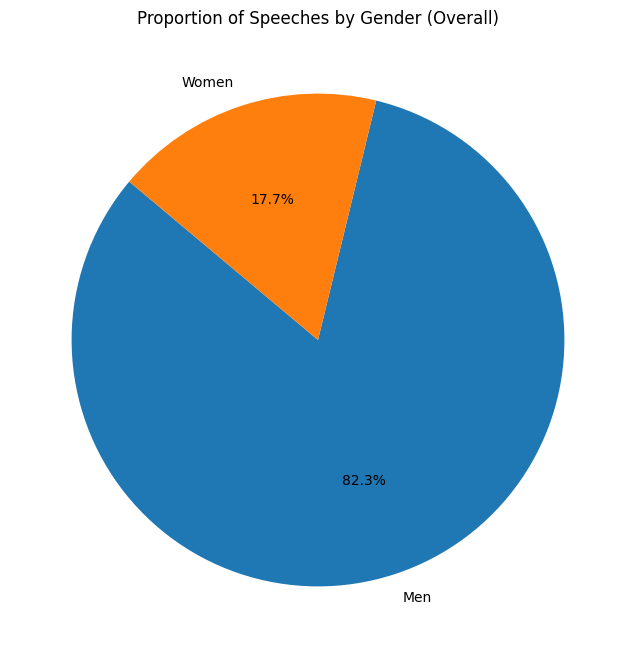

In [14]:
# total count of speeches by gender across the entire dataset
total_gender_counts = speeches['gender'].value_counts()
# rename the index for better labeling
total_gender_counts.index = ['Men' if gender == 'male' else 'Women' for gender in total_gender_counts.index]

# pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    total_gender_counts,
    labels=total_gender_counts.index,
    autopct='%1.1f%%',
    startangle=140,
)
plt.title('Proportion of Speeches by Gender (Overall)')
plt.show()

We observe that women speakers make up less than 20% of the speeches collected. \
This raises questions about statistical validity for the rest of our study: when we compare trends or characteristics between men and women, the smaller sample size for women might lead to less reliable conclusions.

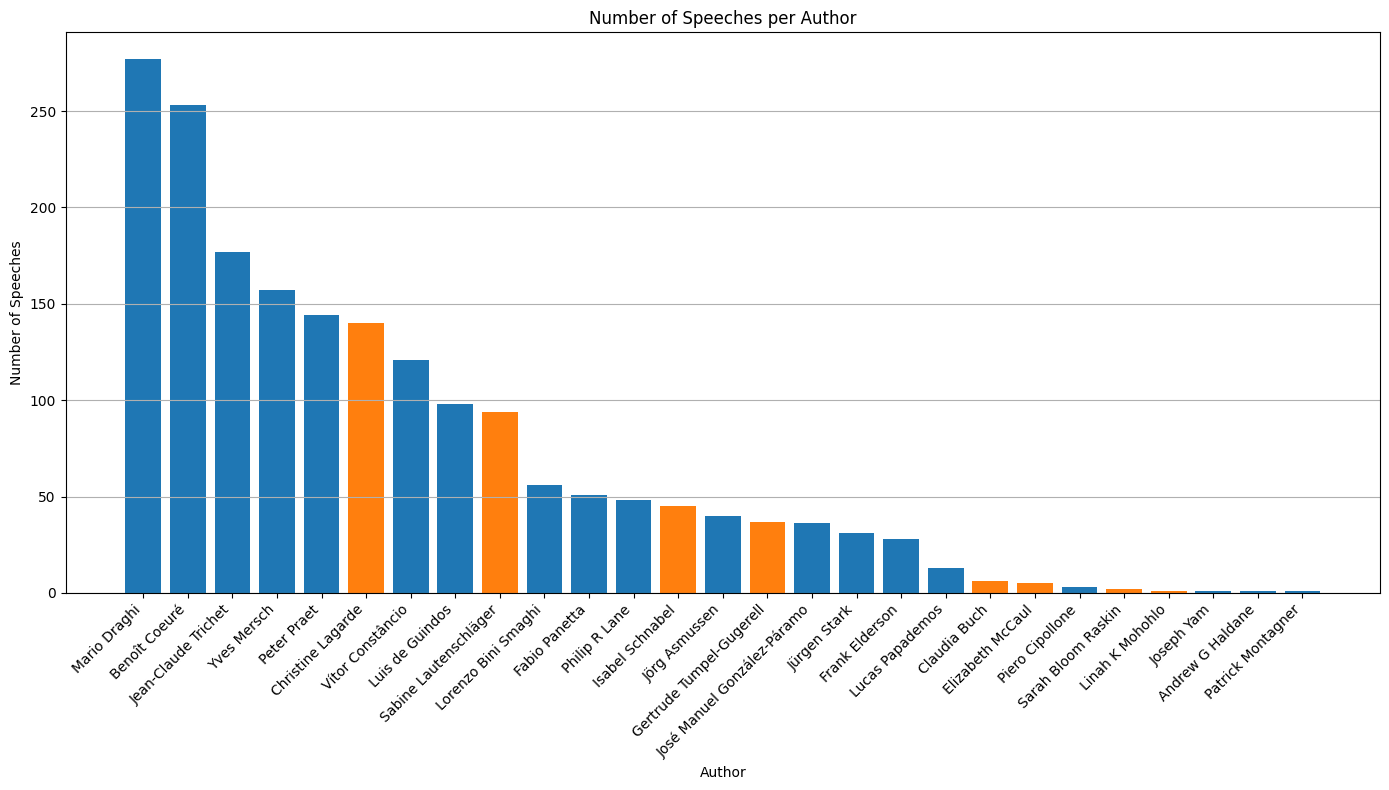

In [15]:
# Count speeches per author
speeches_per_author = speeches['speaker_name'].value_counts()
speeches_per_author = speeches_per_author.rename_axis('speaker_name').reset_index(name='count')

# assign default Matplotlib colors based on gender to match previous colors
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
gender_color_map = {'male': default_colors[0], 'female': default_colors[1], 'unknown': 'gray'}
colors = speeches_per_author['speaker_name'].map(
    lambda name: gender_color_map[fetched_genders[name][0]] if name in fetched_genders else gender_color_map['unknown']
)

# bar chart with colors based on gender
plt.figure(figsize=(14, 8))
plt.bar(speeches_per_author['speaker_name'], speeches_per_author['count'], color=colors)
plt.title("Number of Speeches per Author")
plt.xlabel("Author")
plt.ylabel("Number of Speeches")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


We observe that the top 5 speakers between 2009 and 2024 are men, and only 2 women are in the top 10.

##### Temporal analysis

In [16]:
# Convert 'publication_start_date' to datetime with mixed format handling
# Extract year and month
speeches['converted_date'] = pd.to_datetime(speeches['publication_start_date'], utc=True, format='mixed')
speeches['year'] = speeches['converted_date'].dt.year
speeches['year_month'] = speeches['converted_date'].dt.to_period('M')  # Combines year and month for later graphs

C:\Users\marie\AppData\Local\Temp\ipykernel_10204\1864619153.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  speeches['year_month'] = speeches['converted_date'].dt.to_period('M')  # Combines year and month for later graphs


In [17]:
# Plotting speeches per year and speeches per month
speeches_per_year = speeches.groupby('year').size()
speeches_per_month = speeches.groupby('year_month').size()
speeches_per_month.index = speeches_per_month.index.astype(str)  # Convert PeriodIndex to string

# speeches per year
fig_year = px.line(
    x=speeches_per_year.index, 
    y=speeches_per_year.values, 
    labels={'x': 'Year', 'y': 'Number of Speeches'},
    title="Number of Speeches per Year"
)
fig_year.update_traces(mode="lines+markers")
fig_year.update_layout(
    xaxis=dict(title="Year"),
    yaxis=dict(title="Number of Speeches"),
    template="plotly_white"
)
fig_year.show()

# speeches per month
fig_month = px.line(
    x=speeches_per_month.index, 
    y=speeches_per_month.values, 
    labels={'x': 'Year-Month', 'y': 'Number of Speeches'},
    title="Number of Speeches per Month"
)
fig_month.update_traces(mode="lines+markers")
fig_month.update_layout(
    xaxis=dict(
        title="Year-Month",
        tickmode="array",
        tickvals=speeches_per_month.index[::6],  # Show every 6th month
        ticktext=[str(val) for val in speeches_per_month.index[::6]],  # Convert to string
    ),
    yaxis=dict(title="Number of Speeches"),
    template="plotly_white"
)
fig_month.show()


The number of speeches per year is rather heterogenous, with a drop in 2020 and much less speeches in recent years (2020-2024). \
The monthly distribution allows to look for yearly trend in the speeches distribution. We see that, almost every year (exceptions being 2012, 2017 and 2021), the lowest number of speeches per month happens to be in August.

#### Gender representation over time

In [18]:
speeches_men = speeches[speeches['gender']=='male']
speeches_women = speeches[speeches['gender']=='female']
print(f'Number of speeches by men: {len(speeches_men)}')
print(f'Number of speeches by women : {len(speeches_women)}')

Number of speeches by men: 1536
Number of speeches by women : 330


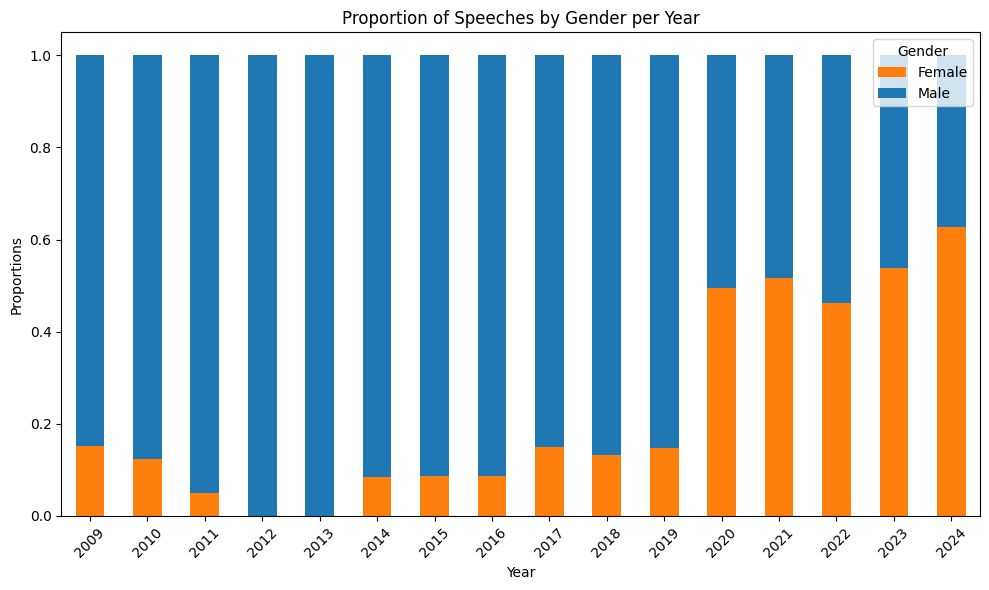

In [19]:
# group by year and gender and count the number of speeches + calculate proportions
gender_counts = speeches.groupby(['year', 'gender']).size().unstack(fill_value=0)
gender_proportions = gender_counts.div(gender_counts.sum(axis=1), axis=0)  # Normalize counts
gender_proportions.plot(kind='bar', stacked=True, figsize=(10, 6), color=[gender_color_map['female'], gender_color_map['male']])

plt.title('Proportion of Speeches by Gender per Year')
plt.xlabel('Year')
plt.ylabel('Proportions')
plt.xticks(rotation=45)
plt.legend(title='Gender', labels=['Female', 'Male'])
plt.tight_layout()
plt.show()

The stacked barplot is very telling of the evolution of the speakers diversity over time : we observe a clear augmentation of women speakers in 2020, which coincides with Christine Lagarde's arrival at the presidence of the BCE. It also coincides with a drop in the total number of speeches per year, men and women alltogether. 

From the previous graph, we also know that Lagarde is the top woman speaker in our dataset, which helps explain this sudden rise.

##### Speeches length analysis

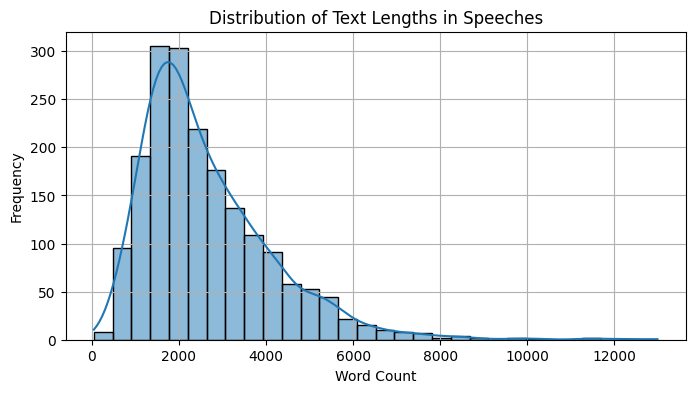

In [20]:
# Word count for each speech
speeches['text_length'] = speeches['speech_content'].apply(lambda x: len(str(x).split()))

# Distribution of text lengths
plt.figure(figsize=(8, 4))
sns.histplot(speeches['text_length'], bins=30, kde=True)
plt.title("Distribution of Text Lengths in Speeches")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

The histogram of speech lengths helps to visualize the variability in content richness.

#### Topic exploration
To get a global idea of what topics the speeches treat of

- Word Frequency Analysis and Word Cloud Visualization using word counts and TFIDF Vectorizer

In [21]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

# Combine all speeches into one text
all_text = " ".join(speeches['speech_content'].dropna())

# Normalize to lowercase and count word frequencies
words = [word.lower() for word in all_text.split()]
word_counts = Counter(words)

# Filter out common stopwords (in english)
stop_words = set(stopwords.words("english"))
filtered_word_counts = {word: count for word, count in word_counts.items() if word not in stop_words}

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    stop_words="english",
    min_df=15,
    max_df=0.8, # not appear in more than 80% of the doc
    ngram_range=(1, 3),
    token_pattern=r"\b[a-zA-Z]{4,}\b", # removes numbers
)
X_ = vectorizer.fit_transform(speeches["speech_content"].values)
cols = vectorizer.get_feature_names_out()

To reduce the impact over large  `tfidf` coefficients, we use the log transformationl $x \mapsto log(1+x)$ 

In [23]:
tfidf_matrix = X_.toarray() # convert the TF-IDF matrix as a dense array
X_tfidf = pd.DataFrame(np.log1p(tfidf_matrix), index=speeches["speech_content"].index, columns=cols)

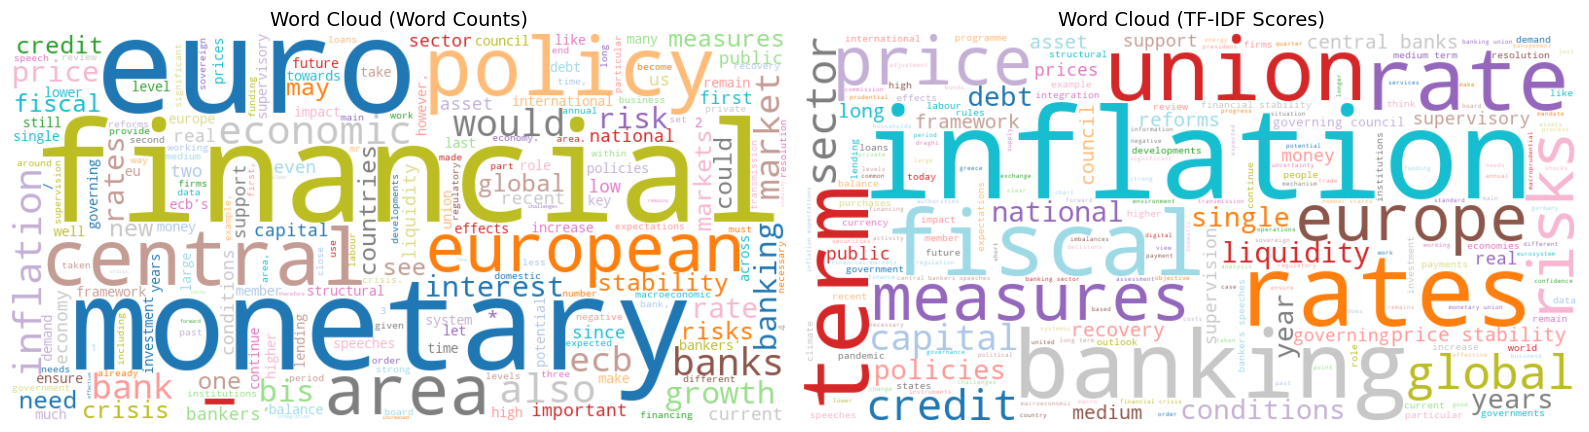

In [24]:
# generate WordCloud according to word counts
wordcloud_counts = WordCloud(width=800, height=400, background_color="white", colormap='tab20').generate_from_frequencies(filtered_word_counts)

# generate WordCloud according to TF-IDF scores
# Calculate the sum of the TF-IDF scores for each term across all speeches
sum_tfidf_scores = tfidf_matrix.sum(axis=0)
# Create a dictionary with words as keys and their total TF-IDF score as values
word_freq = dict(zip(cols, sum_tfidf_scores))
wordcloud_tfidf = WordCloud(width=800, height=400, background_color="white", colormap='tab20').generate_from_frequencies(word_freq)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Word Cloud for Word Counts
axes[0].imshow(wordcloud_counts, interpolation="bilinear")
axes[0].axis("off")
axes[0].set_title("Word Cloud (Word Counts)", fontsize=14)

# Word Cloud for TF-IDF Scores
axes[1].imshow(wordcloud_tfidf, interpolation="bilinear")
axes[1].axis("off")
axes[1].set_title("Word Cloud (TF-IDF Scores)", fontsize=14)

plt.tight_layout()
plt.show()

We represented two word clouds to get a visual insight into which words are most common in the speeches :
1. Word Counts: displays the most frequent words across all speeches in our dataset. This is useful for understanding the key themes or common terms across all speeches, but might include common, less meaningful words that appear frequently.
2. TF-IDF Scores: based on the TF-IDF scores, which measure how important a word is in a document relative to a larger corpus. Words that are more specific to certain documents and less common in the entire dataset will have higher scores (and be shown larger). This is useful to highlight words that are more distinctive or unique to specific speeches, as opposed to general or commonly used words (over multiple speeches). 

By comparing the two word clouds, we get a deeper understanding of both general trends and more context-specific details about the speeches.

The key terms identified in this analysis predominantly relate to monetary policies and central banking activities, including words like financial, monetary, inflation, banking, euro, central bank, etc. This is logical given the context of the speeches, which focus on economic and financial matters in european central banks.

--------


### ANALYTICS AND LEARNING STRATEGY

Central bank speeches, often rich in economic and policy insights, offer a unique lens to analyze gendered communication styles. As mentioned in the introduction, the content and tone of these speeches can influence public perception and financial markets, however, relatively few existing literature focuses in understanding how gender may influence tone and topic selection in such high-stakes settings.
This project attempts to extract topics and sentiments from these speeches, using NLP topic modeling and sentiment analysis tools, in order to explore potential differences in sentiment and thematic focus between male and female central bank leaders.

### 1. Topic Modeling

Topic Modeling is an NLP technique based on unsupervised learning, which aims to extract main topics -in the form of a group of words with a shared theme- from a collection of documents.\
For this task, we will first use one of the most frequently used models : the Latent Dirichlet Allocation (LDA). We will then explore other techniques such as NMF ?? and ??.

#### Preprocess speeches

Text preprocessing is an important step, as it improves model results of most text mining techniques. \
We've already filtered out stopwords, which removes common or semantically irrelevant words. The second step is stemming or lemmatization, which reduce words to their root or base form to normalize variations of words the machine may otherwise separate. Here, we use the en_core_web_sm spacy model to lemmatize, we chose it over a stemmer as it produces more readable words, which are desirable in topic modeling.
Finally, we split the text into tokens.

In [25]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ----- ---------------------------------- 1.8/12.8 MB 10.1 MB/s eta 0:00:02
     ------------- -------------------------- 4.2/12.8 MB 11.5 MB/s eta 0:00:01
     -------------------- ------------------- 6.6/12.8 MB 11.5 MB/s eta 0:00:01
     -------------------------- ------------- 8.4/12.8 MB 10.6 MB/s eta 0:00:01
     -------------------------------- ------ 10.7/12.8 MB 10.7 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 10.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
import spacy
# Load a spaCy model for lemmatization
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# preprocessing function
def preprocess_text(text):
    doc = nlp(text.lower())  # Convert text to lowercase and tokenize
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)

speeches['processed_content_topic_modeling'] = speeches['speech_content'].apply(lambda doc: preprocess_text(doc).split())
# 11m

#### Latent Dirichlet Allocation : 
**LDA** is a generative probabilistic model that assumes documents are mixtures of topics, and topics are mixtures of words.
It approaches documents as bag of words, meaning that it ignores word order and context, and focuses on word co-occurence within each individual document. They are modeled in a *document-term matrix*, in which rows represent documents and columns represent words, and each cell contains the frequency count of a given word in a given document of the corpus.
Using this DT matrix, the LDA algorithm assumes that words that occur together are likely part of similar topics and assigns document-topic distributions based on the clusters of words that appear in the given document.


It uses Gibbs sampling when assigning topics to words, which is an iterative process used to estimate the posterior distributions of the topic-word and document-topic distributions. It passes each word through multiple iterations and updates the topic-word probabilities until convergence or until a set number of iterations is reached.

The Dirichlet distribution is used to model the prior distribution of the topic proportions for each document (𝛼) and the word proportions for each topic (𝜂), influencing the assignment of words to topics during the Gibbs sampling.
<!-- Initially, the algorithm choses random words to be topics. Each word is then assigned to a topic according to a uniform Dirichlet distribution, which forms a first topic model. 
We then take each word and update its topic with the topic that would have the highest proabibilty to generate it in the document.
This process is then repeated through multiple iterations until the algorithm generates an ensemble of topics  -->


**Evaluation** : \
As topic modeling is an unsupervised learning task, it can be challenging to objectively evaluate the quality of the topics. The "best" topics often depend on the specific goals of the analysis and subjective human judgment :

- Qualitative evaluation: this includes *Topic Interpretability* (manually inspecting and interpreting the topics, examining the top five or ten keywords for each topic and ensuring that the words within each topic are coherentand relevant to the topic), *Visualizations* (for instance word clouds to display the most important words for each topic and their relative frequencies, to help assess the topics' quality) or *Human Evaluation* (using expert judgment to rate the quality and interpretability of topics) 

- Quantitative evaluation : The *Topic Coherence* score assesses how interpretable the topics are based on word co-occurrence and similarity between high-scoring words, in order to quantify how coherent a given topic is. 
A model’s overall coherence score averages the coherence score of each individual topic. Coherence scores range from 0 to 1, with higher scores indicating better-defined topics.

- with Document-Term matrix

In [ ]:
from gensim import corpora
from gensim.models import LdaModel

# # Create the document-term matrix
dictionary = corpora.Dictionary(speeches['processed_content_topic_modeling'])
doc_term_matrix = [dictionary.doc2bow(doc) for doc in speeches['processed_content_topic_modeling']]

# LDA model, 6 topics, 13 passes
num_topics = 6
num_passes = 13
lda = LdaModel(corpus=doc_term_matrix, num_topics=num_topics, id2word=dictionary, passes=num_passes, alpha='auto', eta='auto')
topics = lda.print_topics(num_topics=6, num_words=7)
# print topics
for i, topic in topics: 
    print(f"Topic {i+1}: {topic}")

Topic 0: 0.018*"inflation" + 0.014*"policy" + 0.012*"rate" + 0.012*"euro" + 0.012*"area" + 0.012*"monetary" + 0.008*"term"
Topic 1: 0.015*"payment" + 0.015*"euro" + 0.011*"market" + 0.011*"european" + 0.009*"area" + 0.007*"bank" + 0.007*"central"
Topic 2: 0.026*"financial" + 0.018*"risk" + 0.018*"bank" + 0.012*"market" + 0.007*"central" + 0.007*"system" + 0.007*"policy"
Topic 3: 0.016*"bank" + 0.014*"euro" + 0.013*"area" + 0.012*"european" + 0.009*"financial" + 0.009*"country" + 0.008*"union"
Topic 4: 0.025*"policy" + 0.017*"monetary" + 0.015*"rate" + 0.014*"bank" + 0.012*"central" + 0.009*"financial" + 0.008*"price"
Topic 5: 0.010*"ecb" + 0.009*"bank" + 0.009*"central" + 0.009*"policy" + 0.009*"euro" + 0.008*"european" + 0.007*"country"


Topic 1:
['inflation', 'policy', 'rate', 'euro', 'area', 'monetary', 'term', 'growth', 'price', 'economic']



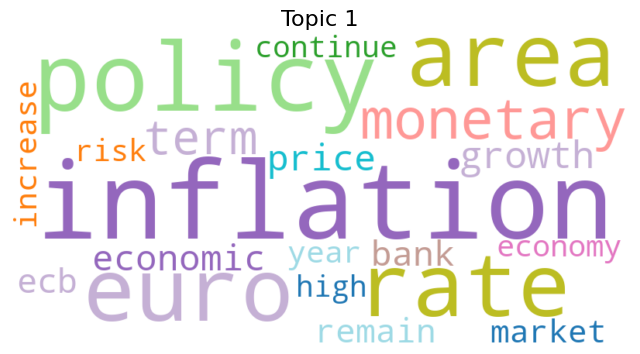

Topic 2:
['payment', 'euro', 'market', 'european', 'area', 'bank', 'central', 'service', 'digital', 'growth']



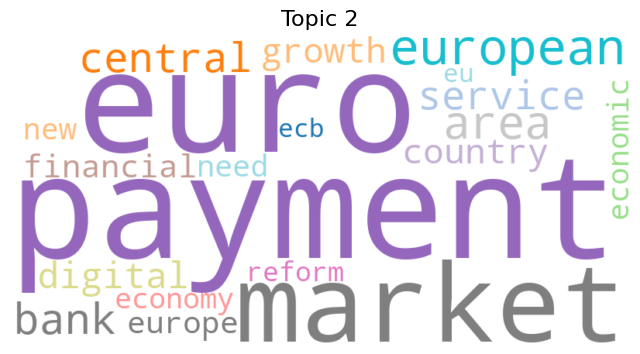

Topic 3:
['financial', 'risk', 'bank', 'market', 'central', 'system', 'policy', 'crisis', 'banking', 'capital']



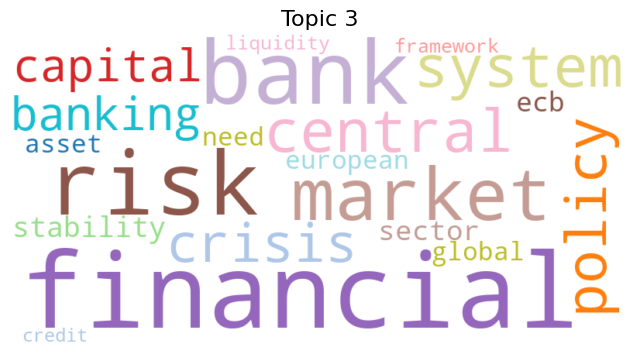

Topic 4:
['bank', 'euro', 'area', 'european', 'financial', 'country', 'union', 'market', 'crisis', 'banking']



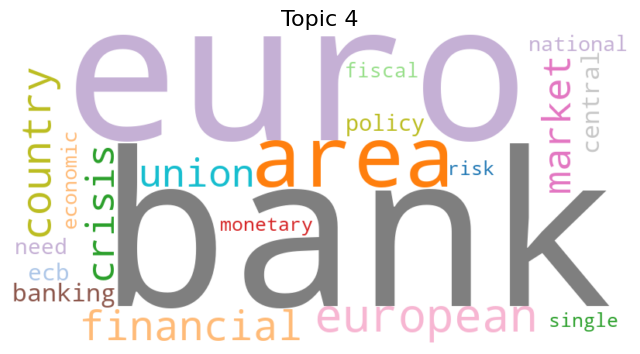

Topic 5:
['policy', 'monetary', 'rate', 'bank', 'central', 'financial', 'price', 'market', 'crisis', 'euro']



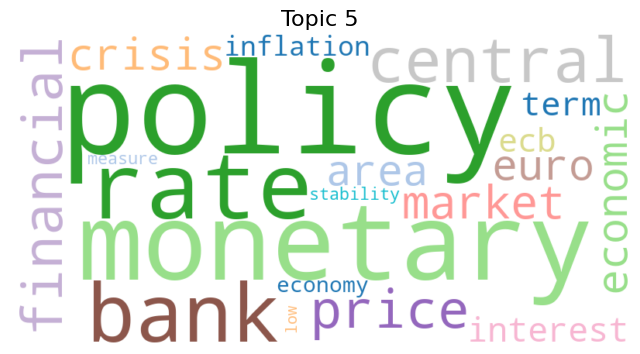

Topic 6:
['ecb', 'bank', 'central', 'policy', 'euro', 'european', 'country', 'rate', 'market', 'monetary']



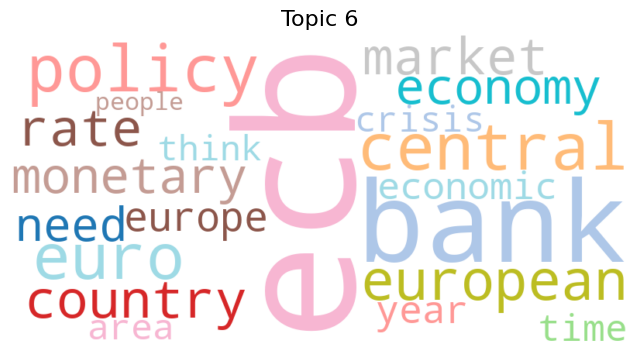

In [70]:
# display the top words + wordcloud for each topic
num_topics = lda.num_topics

for topic_id in range(num_topics):
    top_words = lda.show_topic(topic_id, topn=10)# Get the top 10 words for each topic
    print(f"Topic {topic_id + 1}:")
    print([word for word, prob in top_words])  # Extract just the words
    print()

    # wordcloud
    words = dict(lda.show_topic(topic_id, topn=20))
    wordcloud = WordCloud(width=800, height=400, colormap='tab20',background_color='white').generate_from_frequencies(words)
    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"Topic {topic_id + 1}", fontsize=16)
    plt.axis("off")
    plt.show()

**Training parameters**
- the corpus (*gensim_corpus_tfidf*) used, here it is the document-term matrix, where each document is represented as a bag of words. Later we will explore replacing this DT matrix by a weighted one based on the TFIDF scores of words in the document.
- the number of topics (*num_topics*) that the model will attempt to identify. It is chosen through experimentation / testing multiple values, we will show this process later. Too few topics may oversimplify the model while too many may lead to overfitting and worst interpretation capacities.
- the dictionary (*id2word*), which is a mapping from word IDs to actual words, necessary to interpret the topics.
It is created using the text to modelize using Gensim, and maps each unique word in from the corpus of documents to an ID.
- the number of passes (*num_passes*), which represents the number of times the entire corpus is passed through the model during training. More passes usually lead to more accurate topics but take longer to compute. We will explore different values later.
- The *alpha* parameter, which controls the sparsity of the topic distribution for each document and influences how much topics are shared across documents. Here the 'auto' value lets Gensim choose an optimal value based on the data. 
- The *eta* parameter which controls the sparsity of the word distribution for each topic and influences how specific each topic is to particular words.Here we also set it to 'auto', letting Gensim determine the best value.

**Results**
- *Topic 1*: Focuses on inflation, interest rates, and monetary policy, likely in the Eurozone context.
<!-- Monetary Policy & Inflation -->

- *Topic 2*: Focuses on payment systems, the euro, and European market structures, with references to central banking.
<!-- Payment Systems & the Euro -->

- *Topic 3*: Focuses on financial risk in the banking sector and regulatory policies, particularly from central banks.
<!-- Financial Risks & Banking -->

- *Topic 4*: Focuses on European banking, the euro, and economic integration within the EU.
<!-- European Banking & Economic Union -->

- *Topic 5*: Focuses on the role of central banks in setting interest rates and managing monetary policy.
<!-- Monetary Policy & Interest Rates -->

- *Topic 6*: Focuses on the European Central Bank’s role in central banking, monetary policy, and economic management.
<!-- ECB & Central Banking -->

All in all, the topics are very similar and semantically close. As we could expect, the same words (euro, policy, ...) appear in almost every topic.

In [71]:
from gensim.models import CoherenceModel

# Compute coherence score for the LDA model
coherence_model_lda = CoherenceModel(model=lda, texts=speeches['processed_content_topic_modeling'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f"Coherence Score: {coherence_lda}")

Coherence Score: 0.3430169190753065


We obtain a coherence score of 0.34. Let's now compare topic "distribution" among genders :

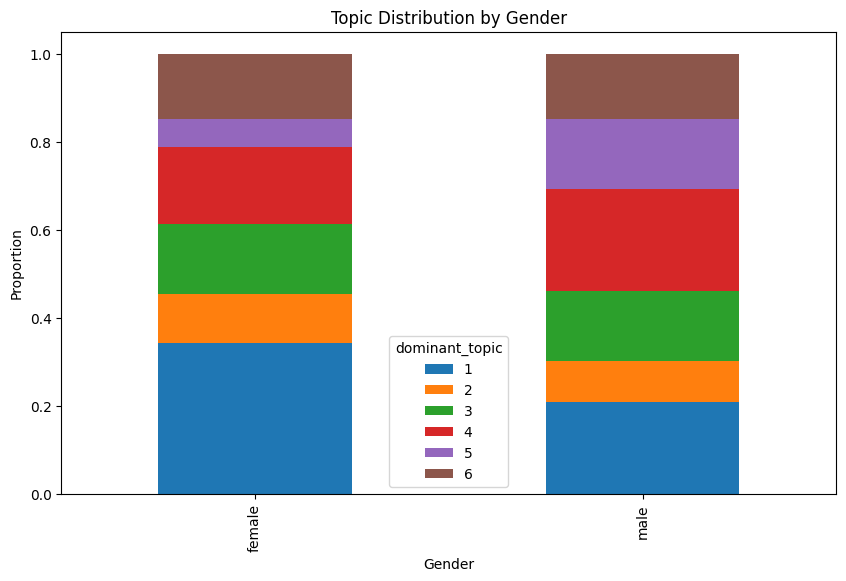

In [82]:
# we assign the dominant topic for each speech
speeches['dominant_topic'] = [max(lda[doc], key=lambda x: x[1])[0]+1 for doc in doc_term_matrix]

# analyze topic distribution by gender
topic_by_gender = speeches.groupby(['gender', 'dominant_topic']).size().unstack().fillna(0)
topic_by_gender = topic_by_gender.div(topic_by_gender.sum(axis=1), axis=0)

# Plot topic distribution by gender
topic_by_gender.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Topic Distribution by Gender")
plt.xlabel("Gender")
plt.ylabel("Proportion")
plt.show()

We can see that the topic distribution is also very similar in both genders, with men focusing slightly more on European Banking & Economic Union (topic 4) and Monetary Policy & Interest Rates (topic 5) than women, who, in return, adress Monetary Policy & Inflation (topic 1) more often. However, these topics are very close and overlap one another, so it is difficult to distinguish a clear difference between the two genders' focus in their speeches. \
The differences in topic distribution are not substantial enough to imply a strong gendered distinction in the content of the speeches, and suggest that they are largely shared across genders.

- with TFIDF

Instead of usign the document-term frequency matrix, we can replace it with a weighted matrix computed with the TDIDF Vectorizer, where word importance is adjusted based on how often it appears across all documents. This change emphasizes distinctive words while downweighting common ones, potentially improving topic coherence by focusing on more informative terms during the LDA process.

In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora
from gensim.models import LdaModel

# join tokens back into strings for TF-IDF processing
speeches['processed_content_topic_modeling_str'] = speeches['processed_content_topic_modeling'].apply(lambda tokens: ' '.join(tokens))

# TFIDF matrix + vocabulary
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)  # Limit the vocabulary size
tfidf_matrix = tfidf_vectorizer.fit_transform(speeches['processed_content_topic_modeling_str'])
tfidf_vocab = tfidf_vectorizer.get_feature_names_out()

# re-tokenize the documents (for Gensim)
tokenized_docs = [doc.split() for doc in speeches['processed_content_topic_modeling_str']]

# Gensim dictionary
gensim_dictionary = corpora.Dictionary(tokenized_docs)

# create a mapping between TFIDF features and Gensim dictionary
vocab_mapping = {word: gensim_dictionary.token2id[word] for word in tfidf_vocab if word in gensim_dictionary.token2id}

# convert the TFIDF matrix to Gensim format
gensim_corpus_tfidf = [
    [(vocab_mapping[tfidf_vocab[i]], tfidf_value) for i, tfidf_value in zip(tfidf_matrix.getrow(doc_idx).indices, tfidf_matrix.getrow(doc_idx).data) if tfidf_vocab[i] in vocab_mapping]
    for doc_idx in range(tfidf_matrix.shape[0])
]

#train the model
lda_tfidf = LdaModel(corpus=gensim_corpus_tfidf, num_topics=num_topics, id2word=gensim_dictionary, passes=num_passes, alpha='auto', eta='auto')
topics_tfidf = lda_tfidf.print_topics(num_topics=8, num_words=5)
for i, topic in topics_tfidf:
    print(f"Topic {i+1}: {topic}")

Topic 1: 0.000*"bank" + 0.000*"euro" + 0.000*"area" + 0.000*"policy" + 0.000*"financial"
Topic 2: 0.000*"policy" + 0.000*"inflation" + 0.000*"bank" + 0.000*"monetary" + 0.000*"financial"
Topic 3: 0.008*"bank" + 0.007*"policy" + 0.007*"euro" + 0.006*"financial" + 0.006*"area"
Topic 4: 0.000*"policy" + 0.000*"bank" + 0.000*"euro" + 0.000*"financial" + 0.000*"area"
Topic 5: 0.000*"euro" + 0.000*"policy" + 0.000*"inflation" + 0.000*"area" + 0.000*"monetary"
Topic 6: 0.000*"bank" + 0.000*"financial" + 0.000*"euro" + 0.000*"policy" + 0.000*"european"


In [83]:
from gensim.models import CoherenceModel

# Compute coherence score for the LDA model
coherence_model_lda = CoherenceModel(model=lda_tfidf, texts=speeches['processed_content_topic_modeling'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f"Coherence Score: {coherence_lda}") # 0.30

Coherence Score: 0.30685593480175205


For the same parameters of the LDA model, we obtain a worse coherence score, as well as very similar topics, so we stick to the Document-Text matrix method.

#### Non-Negative Matrix Factorization (NMF) :
Another algorithm that aims to group tokens into topics that explain differences across documents is the non-negative matrix factorisation (NMF): for a non-negative matrix $X$ (such as the one with tfidf scores or the document-text matrix mentioned before), the algorithm finds two other non-negative matrices such that $$ X \approx \hat{X}_n H_n^T. $$

The number of topics determines the number of columns in $X_n$ and the number of rows in $H_n$. \
The algorithm aims to approximate the chosen matrix through non-negative factors.

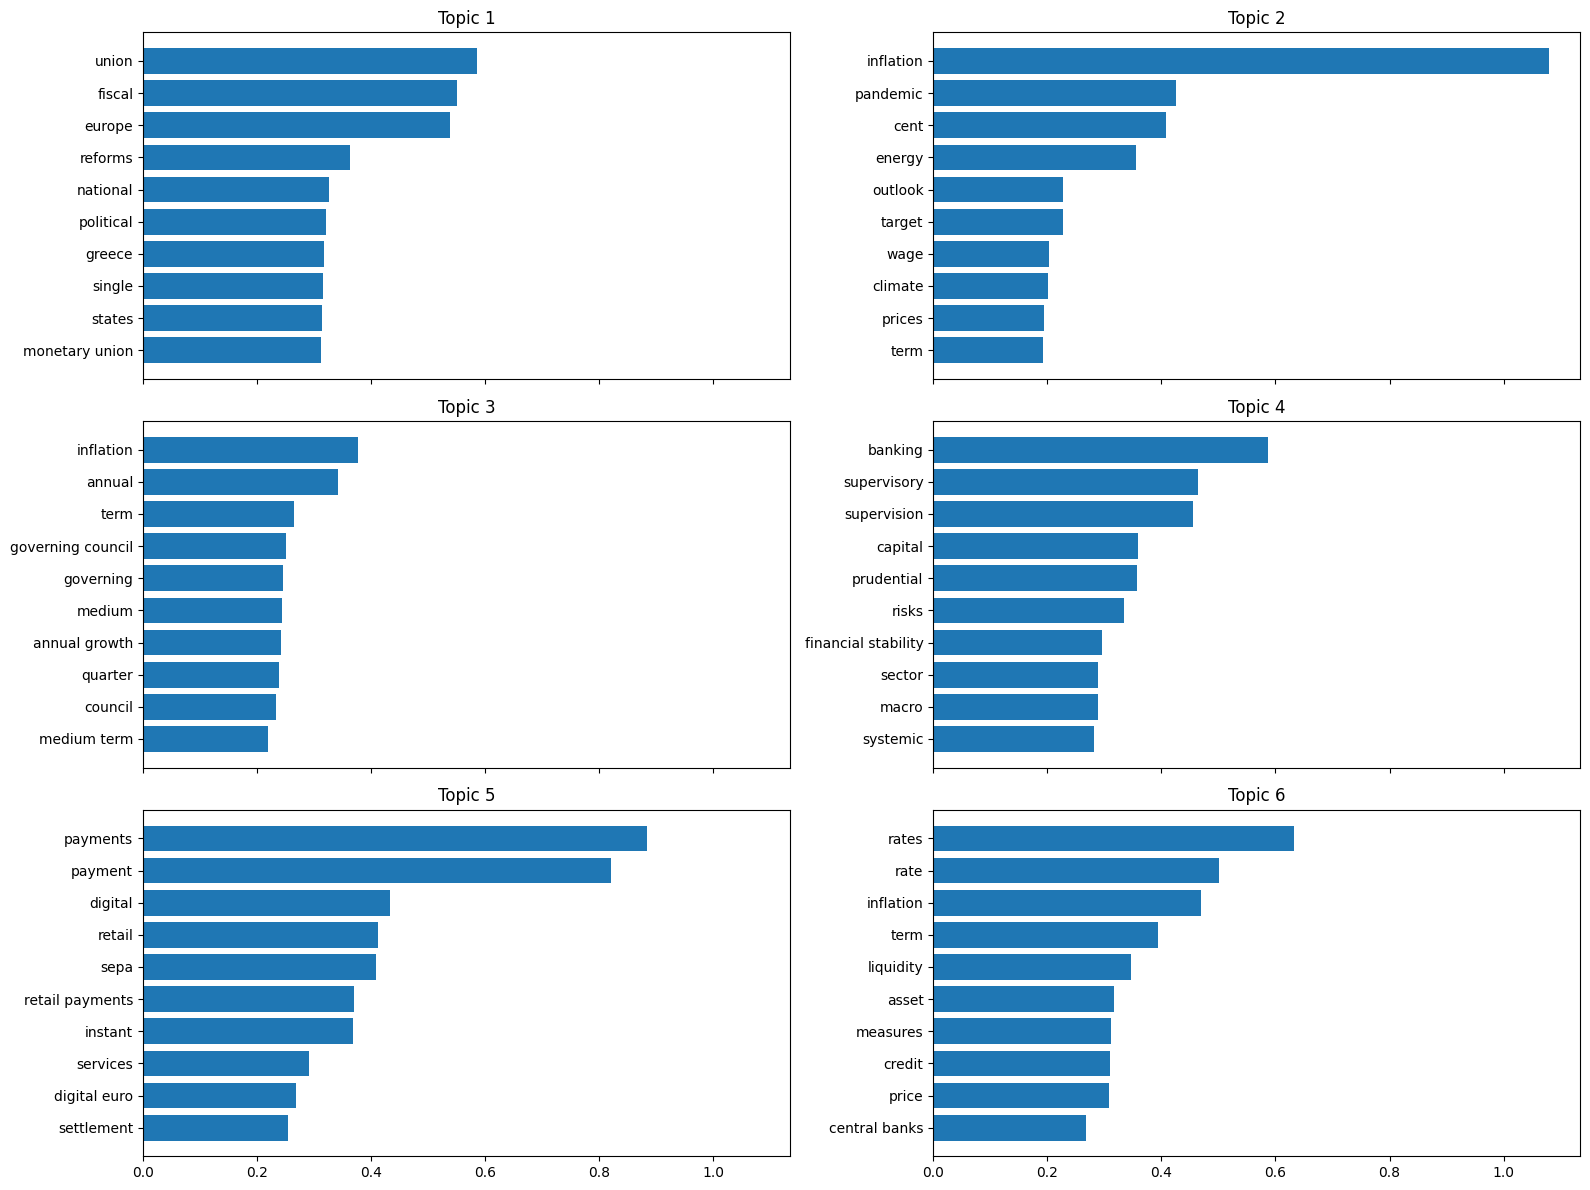

In [92]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=6, random_state=42, max_iter=500)
nmf.fit(X_tfidf) # fit the model

cols = vectorizer.get_feature_names_out()
H2_ = pd.DataFrame(nmf.components_, columns=cols)

# plot the top words for each topic
n_topics = 6  # Number of topics to display
n_top_words = 10  # Number of top words per topic

fig, axes = plt.subplots(n_topics // 2, 2, figsize=(16, 12), sharex=True)
axes = axes.ravel()

for topic_idx, ax in enumerate(axes[:n_topics]):
    top_words = H2_.iloc[topic_idx].sort_values(ascending=False).head(n_top_words)
    ax.barh(top_words.index, top_words.values)
    ax.set_title(f"Topic {topic_idx + 1}")
    ax.invert_yaxis()  # display the highest value at the top

plt.tight_layout()
plt.show()


We find that :
- *topic 1* focuses on the fiscality of the european union
- *topic 2* focuses on the inflation, the pandemic and the climate
- *topic 3* focuses on the inflation and the governing council
- *topic 4* focuses on the banking supervision
- *topic 5* focuses on different means of payment
- *topic 6* focuses on rates, liquidity and prices

These topics appear to be slightly more distinct than the ones found with the LDA, with maybe less overlapping. Let's observe their distribution in men vs women :

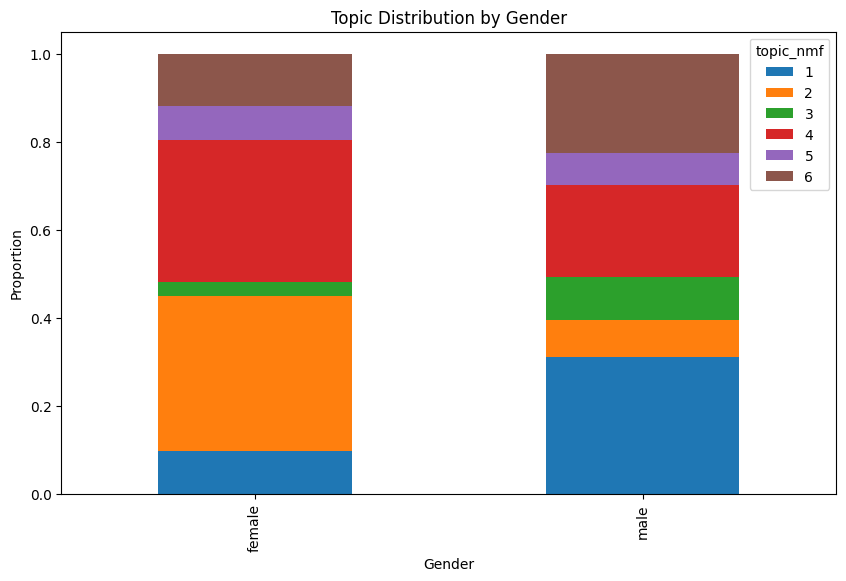

In [94]:
topic_assignments = nmf.transform(X_tfidf)
speeches['topic_nmf'] = topic_assignments.argmax(axis=1)+1 # Assign the dominant topic for each speech

# Analyze topic distribution by gender
topic_by_gender = speeches.groupby(['gender', 'topic_nmf']).size().unstack().fillna(0)
topic_by_gender = topic_by_gender.div(topic_by_gender.sum(axis=1), axis=0)

# Plot topic distribution by gender
topic_by_gender.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Topic Distribution by Gender")
plt.xlabel("Gender")
plt.ylabel("Proportion")
plt.show()


The topic distribution appear to be more different than the one obtained with the LDA model. We find that, comparatively,  men focus more on the fiscality of the european union (topic 1) and marginally more on rates and prices (topic 6), while women focus more on banking supervision (topic 4) than men, as well as significantly more on the inflation/pandemic/climate (topic 2).

##### Attempt to use BERTopic to model topics from the speeches, but not enough time to thoroughly test the model and its capacities

In [37]:
# from bertopic import BERTopic
# # initialize the BERTopic model
# topic_model = BERTopic()

# # Train the model on the speech content
# topics, probs = topic_model.fit_transform(speeches['processed_content_topic_modeling_str'])

# topic_model.get_topic_info()
# # Display the top 10 words for each topic
# for topic in range(len(topic_model.get_topics())):
#     print(f"Topic {topic}: {topic_model.get_topic(topic)}")
# topic_model.visualize_topics()

Topic 0: [('euro', 0.019768487928313764), ('area', 0.01975433235053792), ('monetary', 0.018394601662922207), ('policy', 0.01770508648663809), ('inflation', 0.016186048539386107), ('growth', 0.015262185382793537), ('economic', 0.014301289946685287), ('rate', 0.014071742195854083), ('country', 0.013094140914307743), ('price', 0.012101220190114703)]
Topic 1: [('market', 0.016355659128955327), ('bank', 0.01575001799531636), ('euro', 0.01571022045211244), ('rate', 0.015251825719097358), ('central', 0.015162909136744623), ('policy', 0.014839606606961117), ('area', 0.014306166969297469), ('monetary', 0.012272081850571643), ('european', 0.011877845303671294), ('ecb', 0.01183569918991695)]
Topic 2: [('policy', 0.01967643104233063), ('rate', 0.01806539383343556), ('bank', 0.017629027682127794), ('monetary', 0.016906217606980415), ('inflation', 0.01612104572985139), ('central', 0.015543237085485722), ('area', 0.014777028845676323), ('euro', 0.013927259280403384), ('term', 0.013468797466059912), (

### 2. Sentiment Analysis

#### 1st approach : Loughran-McDonals sentiment lexicon
English sentiment lexicon created for use with financial documents. This lexicon labels words with six possible sentiments important in financial contexts: "negative", "positive", "litigious", "uncertainty", "constraining", or "superfluous".\
Here, we want to use Loughran McDonald's to examine sentiment / tone differences between both genders.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [97]:
# we download the dictionary
logger = logging.getLogger(__name__)

def load_loughran_mcdonald_dictionary(cache_dir="data", force_reload=False):
    """
    Loads the Loughran-McDonald Master Dictionary.
    If the file doesn't exist locally, downloads it from the external source.
    
    Parameters:
        cache_dir (str): Directory to cache the file.
        force_reload (bool): Whether to force downloading the file again.
    
    Returns:
        pd.DataFrame: Loaded dictionary as a DataFrame.
    """
    # Ensure the cache directory exists
    cache_dir = Path(cache_dir)
    cache_dir.mkdir(parents=True, exist_ok=True)
    
    # Filepath for the dictionary
    filename = cache_dir / "Loughran-McDonald_MasterDictionary_1993-2021.csv"
    
    if filename.exists() and not force_reload:
        logger.info(f"Loading from cache file: {filename}")
    else:
        logger.info("Loading from external source")
        id = "17CmUZM9hGUdGYjCXcjQLyybjTrcjrhik"
        url = f"https://docs.google.com/uc?export=download&id={id}"
        
        try:
            # Download file using requests
            response = requests.get(url, stream=True)
            response.raise_for_status()  # Raise an error for bad HTTP status codes
            
            with open(filename, "wb") as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            logger.info(f"Downloaded file to {filename}")
        except requests.RequestException as e:
            logger.error(f"Error downloading file: {e}")
            raise
    
    # Ensure the file exists after the operation
    if not filename.exists():
        raise FileNotFoundError(f"Failed to download file: {filename}")
    
    # Load the CSV file into a DataFrame
    return pd.read_csv(filename)

lm = load_loughran_mcdonald_dictionary()

In [98]:
# filter the dictionary for relevant sentiment categories
sentiment_categories = ['Positive', 'Negative', 'Uncertainty', 'Litigious', 'Constraining']
lm_sentiment_words = lm[['Word'] + sentiment_categories].set_index('Word').fillna(0)

In [99]:
# create the sentiment counts dataframes for men and women

X_men = speeches_men['speech_content']
X_women = speeches_women['speech_content']
funcs = {
    "negative": lambda x: x.Negative > 0,
    "positive": lambda x: x.Positive > 0,
    "all": lambda x: x.Word.notna(),
}

def get_total_count(X, lm, func):
    m = CountVectorizer(vocabulary=lm.loc[func].Word.str.lower().values)
    return pd.DataFrame(m.fit_transform(X).toarray(), index=X.index).sum(axis=1)


lm_counts_men = pd.concat({k: get_total_count(X_men, lm, v) for k, v in funcs.items()}, axis=1)
lm_counts_women = pd.concat({k: get_total_count(X_women, lm, v) for k, v in funcs.items()}, axis=1)

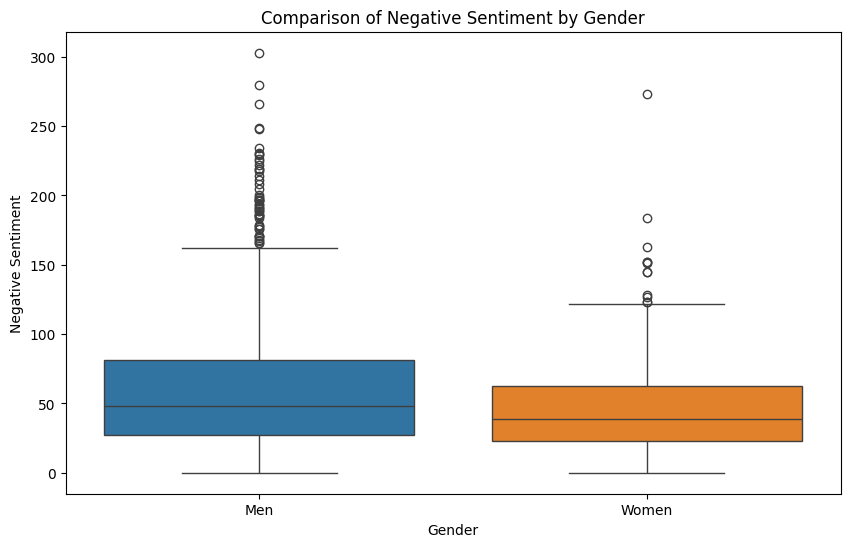

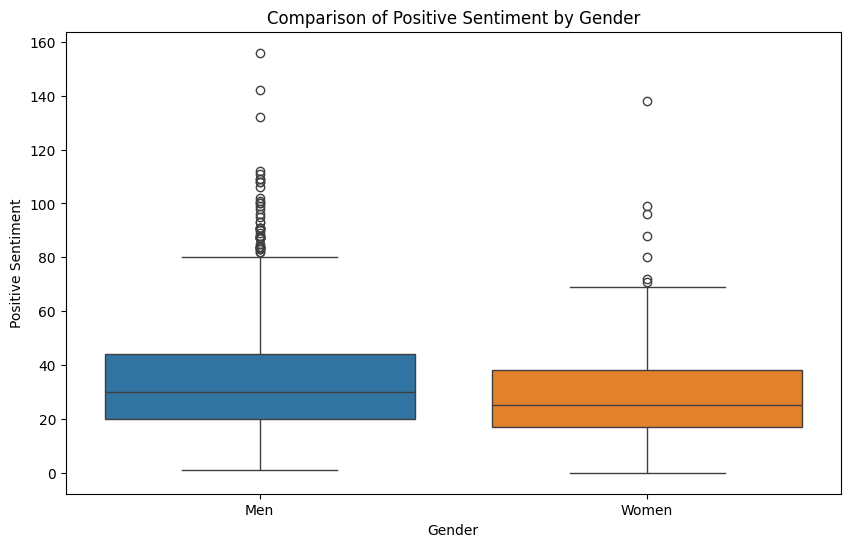

In [101]:
# Plot negatove and positive sentiments in men and women
lm_counts_men['date'] = pd.to_datetime(speeches_men['converted_date'])
lm_counts_men = lm_counts_men.set_index('date')
lm_counts_women['date'] = pd.to_datetime(speeches_women['converted_date'])
lm_counts_women = lm_counts_women.set_index('date')
lm_counts_men['gender'] = 'Men'
lm_counts_women['gender'] = 'Women'
lm_counts_combined = pd.concat([lm_counts_men, lm_counts_women])

# Negative
plt.figure(figsize=(10, 6))
sns.boxplot(x='gender', y='negative', data=lm_counts_combined, palette="tab10")
plt.title("Comparison of Negative Sentiment by Gender")
plt.xlabel("Gender")
plt.ylabel("Negative Sentiment")
plt.show()

# Positive
plt.figure(figsize=(10, 6))
sns.boxplot(x='gender', y='positive', data=lm_counts_combined, palette="tab10")
plt.title("Comparison of Positive Sentiment by Gender")
plt.xlabel("Gender")
plt.ylabel("Positive Sentiment")
plt.show()


We find that men have higher median in both negative and postive sentiments, as well as larger variability. This could suggest that men's speeches are more emotionally charged and may cover a wider emotional spectrum, reflecting a tendency to express contrasting sentiments more frequently or strongly. 
A higher median for negative sentiment suggests men might be more critical, pessimistic, or focused on challenges in their speeches, while a higher median for positive sentiment implies they may also emphasize optimism or solutions more often. \
Men might adopt a more assertive or persuasive tone than women, which could involve emphasizing both problems and resolutions more explicitly.

In [103]:
# Filter speeches after 2022  for better readability
date_filter = "2022-01-01" #"2020-01-01"
lm_counts_men_filtered = lm_counts_men[lm_counts_men.index >= date_filter]
lm_counts_women_filtered = lm_counts_women[lm_counts_women.index >= date_filter]

# Calculate sentiment score for women and men after 2022
sentiment_women = (
    lm_counts_women_filtered.pipe(lambda x: (x.positive - x.negative) / x["all"])
    .resample("B")
    .last()
    .ffill()
)
sentiment_men = (
    lm_counts_men_filtered.pipe(lambda x: (x.positive - x.negative) / x["all"])
    .resample("B")
    .last()
    .ffill()
)

fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.1,
    subplot_titles=["Sentiment Over Time (After 2022): Men", "Sentiment Over Time (After 2022): Women"],
)

# Men's sentiment
fig.add_trace(
    go.Scatter(
        x=sentiment_men.index,
        y=sentiment_men,
        mode='lines+markers',
        name="Men's Sentiment",
        line=dict(color='blue', width=1.5),
        marker=dict(size=4),
        showlegend=False,
    ),
    row=1, col=1
)
# Women's sentiment
fig.add_trace(
    go.Scatter(
        x=sentiment_women.index,
        y=sentiment_women,
        mode='lines+markers',
        name="Women's Sentiment",
        line=dict(color='red', width=1.5),
        marker=dict(size=4),
        showlegend=False
    ),
    row=2, col=1
)

fig.update_layout(
    title="Sentiment Analysis Over Time (After 2022)",
    yaxis_title="Sentiment Score",
    xaxis=dict(showgrid=True, tickangle=45),
    yaxis=dict(showgrid=True),
    template="plotly_white",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)
fig.show()


/!\ men's sentiment scores goes down to -0.04 while women's minimum is -0.02.

For better readability, we focus on the 2022-2024 period, which is also a period where the amount of men vs women speeches is more balanced. It is difficult to observe the same patterns in mean and women speeches across the same period, however, we can see that positive sentiment scores often coincide, notably in the july22-july23 time period.

#### Longformer


2nd approach : There are few algorithms available to treat sentiment analysis for long texts, I tried using the Longformer algorithm, however, without a GPU a least, I couldn't get it to run on our dataset in a reasonable time (overnight). I included the code but unfortunately I don't have any results to provide. \
**However**, I wouldn't expect amazing results as, historically, sentiment analysis has not been providing great results on long texts (which I wasn't aware of before choosing my project's direction as this is my first NLP project). This can be explained by the fact that long and structured texts may contain segments of "positive" sentiment along with "negative" ones and can be more nuanced, there may be several different subjects and several different sentiments about each subject, so trying to simply label it overall as "positive/negative" is rather futile.


In [45]:
from transformers import LongformerTokenizer
from transformers import pipeline

# Initialize the tokenizer for Longformer
tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")
# Load Longformer for sentiment analysis
sentiment_pipeline = pipeline("sentiment-analysis", model="allenai/longformer-base-4096")

# # Apply tokenization to processed speech content
# speeches['longformer_tokens'] = speeches['processed_content_topic_modeling_str'].apply(lambda x: len(tokenizer.encode(x)))

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
# View speeches with token length greater than 4096
speeches['processed_content_topic_modeling_length'] = speeches['processed_content_topic_modeling'].apply(len)
long_speeches = speeches[speeches['processed_content_topic_modeling_length'] > 4096]
# Count how many such speeches exist
print(f"Number of speeches longer than 4096 tokens: {len(long_speeches)}")
# long_speeches['processed_content_topic_modeling_length']
# truncate those to fit the model
max_length = 4096
speeches['processed_content_topic_modeling'] = speeches['processed_content_topic_modeling'].apply(
    lambda tokens: tokens[:max_length] if len(tokens) > max_length else tokens)

Number of speeches longer than 4096 tokens: 26


In [47]:
# Apply sentiment analysis
# speeches['sentiment_longformer'] = speeches['processed_content_topic_modeling'].apply(lambda x: sentiment_pipeline(x)[0]['label'])

In [48]:
# print(speeches['sentiment_longformer'].unique())
# # Count sentiment frequencies
# sentiment_counts = speeches['sentiment_longformer'].value_counts()
# sentiment_counts

### EMPIRICAL RESULTS : BASELINE AND ROBUSTNESS

##### Parameter sensitivity tests :

In this section, we want to determine the optimal number of topics and passes for an LDA model by evaluating the coherence score, which measures the interpretability of the topics, for multiple parameter values.

- Number of topics

For each number of topics, an LDA model is trained on the DT matrix.
After training, the coherence score is calculated using the CoherenceModel and stored for plotting and analysis. \
The coherence score helps find the balance between having too few topics (overgeneralization) and too many topics (fragmentation). By plotting coherence against the number of topics, we want to identify the best trade-off where the topics are meaningful and interpretable.

In [ ]:
def evaluate_coherence(dictionary, doc_term_matrix, texts, num_topics_range, passes=10):
    coherence_scores = []
    for num_topics in tqdm(num_topics_range):
        # Train LDA model
        lda_model = LdaModel(corpus=doc_term_matrix, num_topics=num_topics, id2word=dictionary, passes=passes)
        
        # Compute coherence score
        coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append(coherence_score)
    
    return coherence_scores

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [55:56<00:00, 372.97s/it]


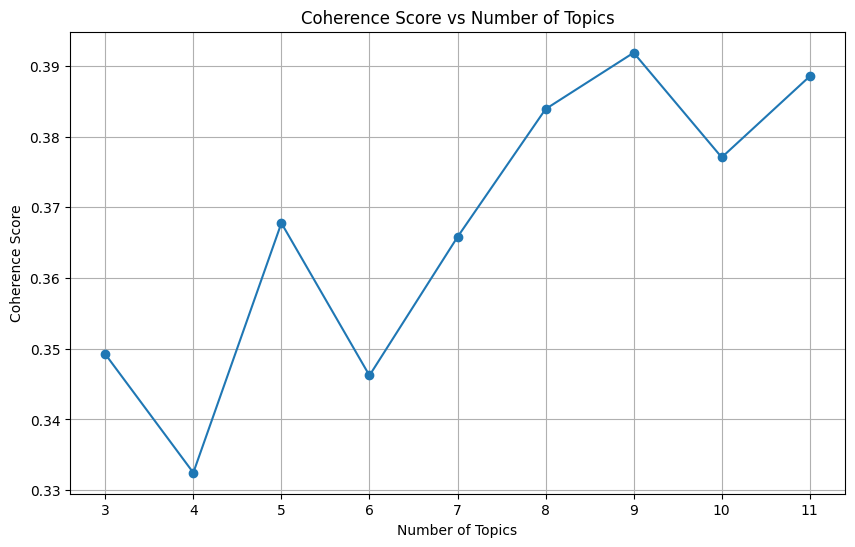

In [ ]:
# Define the range of topics to evaluate
num_topics_range = range(3, 18)

# Evaluate coherence scores for different numbers of topics
coherence_scores = evaluate_coherence(dictionary, doc_term_matrix, speeches['processed_content_topic_modeling'], num_topics_range, passes=20)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(num_topics_range, coherence_scores, marker='o')
plt.title('Coherence Score vs Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.grid(True)
plt.show()
# 133 min

We see that the higher the number of topics, the higher the coherence score of these topics is. However, the absolute improvement is small with only 0.08 of absolute difference between the lowest and the highest coherence.
Moreover, more topics can be more difficult to interpret / manage as they may lead to redundancy or overlap, making it harder to draw clear distinctions between themes or gain insights from the model.

  0%|          | 0/9 [00:00<?, ?it/s]

Topic 1:
['area', 'euro', 'monetary', 'policy', 'economic', 'growth', 'inflation', 'financial', 'price', 'rate']



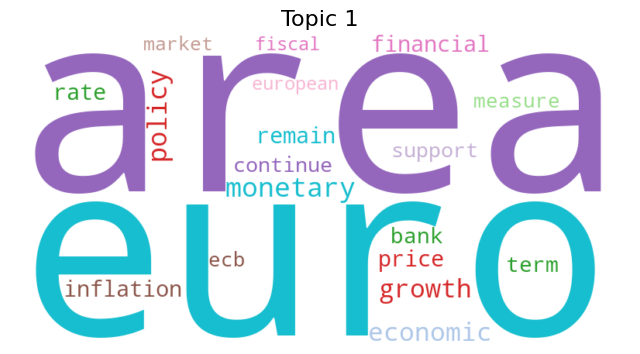

 11%|█         | 1/9 [00:00<00:04,  1.73it/s]

Topic 2:
['inflation', 'pandemic', 'high', 'euro', 'policy', 'energy', 'rate', '2022', 'remain', 'cent']



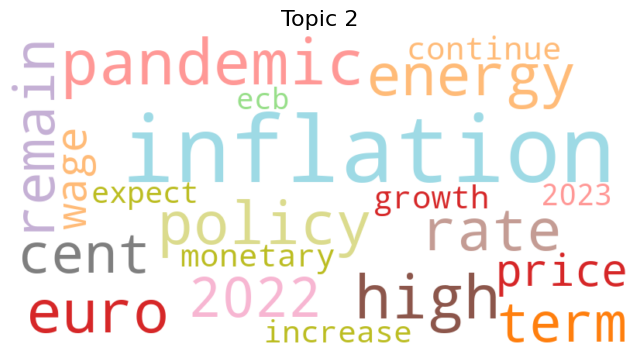

 22%|██▏       | 2/9 [00:01<00:03,  1.82it/s]

Topic 3:
['euro', 'area', 'country', 'european', 'crisis', 'bank', 'policy', 'central', 'market', 'ecb']



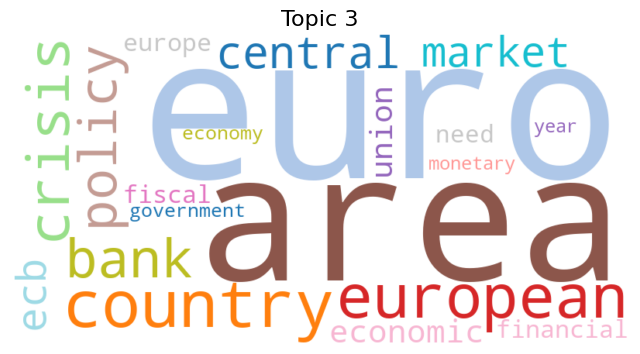

 33%|███▎      | 3/9 [00:01<00:03,  1.64it/s]

Topic 4:
['payment', 'market', 'euro', 'european', 'service', 'bank', 'central', 'digital', 'area', 'europe']



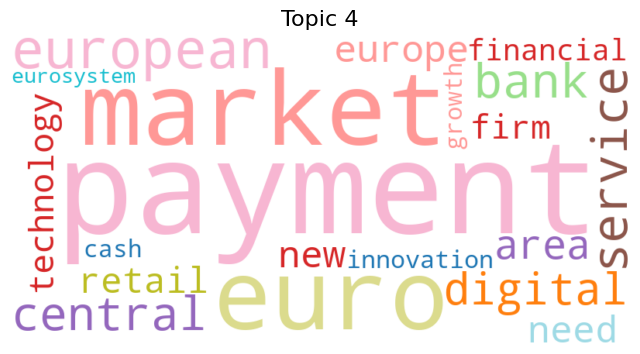

 44%|████▍     | 4/9 [00:02<00:02,  1.67it/s]

Topic 5:
['global', 'policy', 'international', 'economy', 'economic', 'euro', 'growth', 'monetary', 'country', 'area']



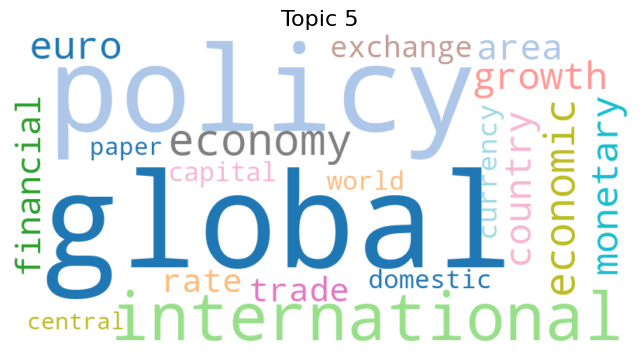

 56%|█████▌    | 5/9 [00:03<00:02,  1.60it/s]

Topic 6:
['bank', 'market', 'financial', 'rate', 'liquidity', 'central', 'asset', 'policy', 'credit', 'risk']



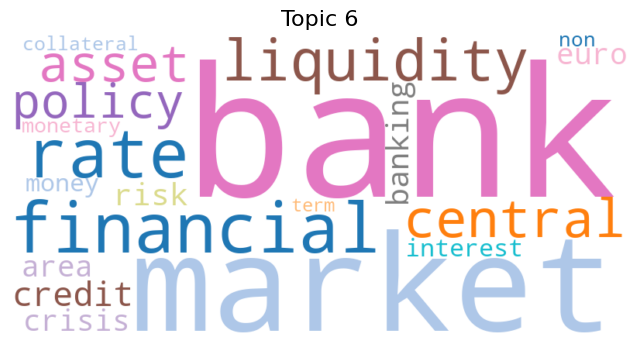

 67%|██████▋   | 6/9 [00:03<00:01,  1.65it/s]

Topic 7:
['financial', 'bank', 'risk', 'market', 'central', 'banking', 'european', 'system', 'stability', 'crisis']



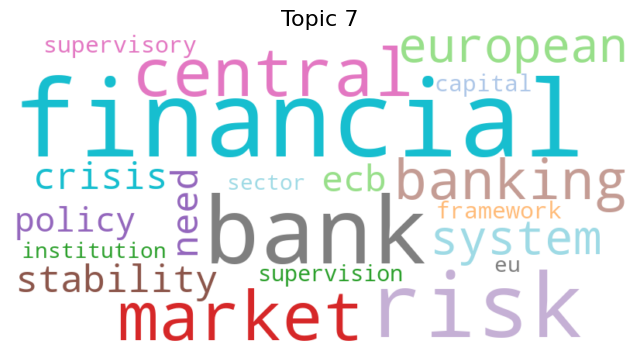

 78%|███████▊  | 7/9 [00:04<00:01,  1.77it/s]

Topic 8:
['policy', 'inflation', 'monetary', 'price', 'ecb', 'economic', 'rate', 'change', 'central', 'bank']



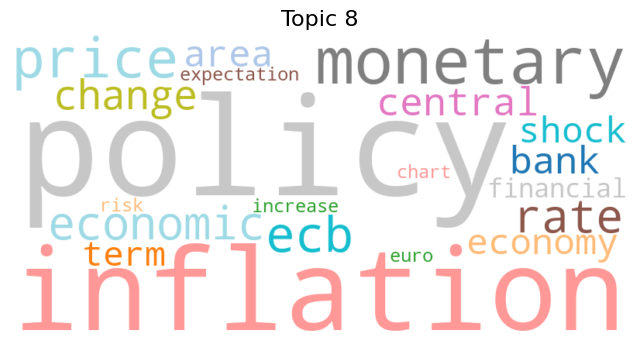

 89%|████████▉ | 8/9 [00:04<00:00,  1.69it/s]

Topic 9:
['policy', 'rate', 'monetary', 'inflation', 'bank', 'central', 'interest', 'term', 'ecb', 'purchase']



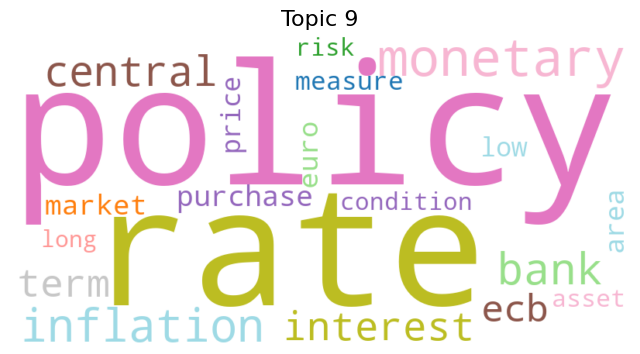

100%|██████████| 9/9 [00:05<00:00,  1.65it/s]


In [ ]:
# Show results
best_num_topics = 10
lda = LdaModel(corpus=doc_term_matrix, num_topics=best_num_topics, id2word=dictionary, passes=20)

# display the top words + wordcloud for each topic
num_topics = lda.num_topics

for topic_id in tqdm(range(num_topics)):
    # Get the top 10 words for each topic
    top_words = lda.show_topic(topic_id, topn=10)
    print(f"Topic {topic_id + 1}:")
    print([word for word, prob in top_words])  # Extract just the words
    print()

    # wordcloud
    words = dict(lda.show_topic(topic_id, topn=20))  # Get top 20 words for the topic
    wordcloud = WordCloud(width=800, height=400, colormap='tab20', background_color='white').generate_from_frequencies(words)
    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"Topic {topic_id + 1}", fontsize=16)
    plt.axis("off")
    plt.show()
#6min

- Number of passes (evaluate how varying the passes parameter affects the coherence score.)

We lead the same analysis on multiple number of passes for the same number of topics :
For each number of passes, an LDA model is trained on the DT matrix.
After training, the coherence score is calculated using the CoherenceModel and stored for plotting and analysis. \
By plotting coherence against the number of passes, we want to identify the best trade-off where the topics are meaningful and interpretable and the training doesn't take too long.

100%|██████████| 4/4 [16:16<00:00, 244.01s/it]


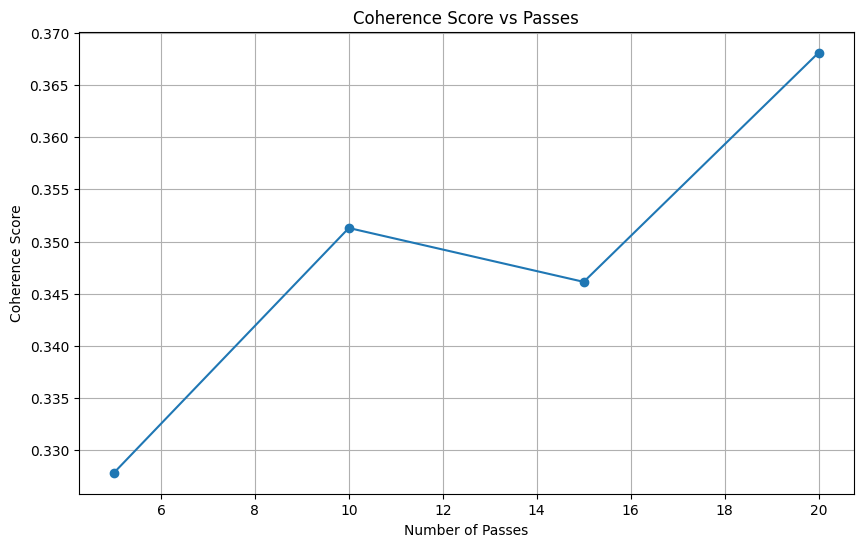

In [ ]:
# Define a fixed number of topics and vary passes
passes_range = range(5, 21, 5)
num_topics = 8  # Choose a fixed number of topics

coherence_scores_passes = []
for passes in tqdm(passes_range):
    lda_model = LdaModel(corpus=doc_term_matrix, num_topics=num_topics, id2word=dictionary, passes=passes)
    coherence_model = CoherenceModel(model=lda_model, texts=speeches['processed_content_topic_modeling'], dictionary=dictionary, coherence='c_v')
    coherence_scores_passes.append(coherence_model.get_coherence())

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(passes_range, coherence_scores_passes, marker='o')
plt.title('Coherence Score vs Passes')
plt.xlabel('Number of Passes')
plt.ylabel('Coherence Score')
plt.grid(True)
plt.show()
# 20min

We can see that the higher the number of passes, the better the coherence. However, once again, the gain on coherence is very small with only 0.04 gained between 5 and 20 passes. For a higher number of passes, the gain is marginal so -at least here- it doesn't make a huge difference whether the data goes through 5, 10 or 20 passes and increasing passes tends to stabilizes the coherence score rather than significantly improve it.

- Hyperparameter exploration with Grid Search 

Here we regroup the 2previous analysis by testing combinations of the two LDA hyperparameters:
- num_topics: The number of topics to extract from the dataset.
- passes: The number of passes (iterations) over the dataset during training.

For each combination of num_topics and passes, an LDA model is trained and the model's coherence score (c_v) is computed, which will help us assess which combination is better. 

In [ ]:
passes_range = range(10, 26, 5)
num_topics_range = range(5, 12)

results = []
for num_topics in tqdm(num_topics_range):
    for passes in tqdm(passes_range):
        lda_model = LdaModel(corpus=doc_term_matrix, num_topics=num_topics, id2word=dictionary, passes=passes)
        coherence_model = CoherenceModel(model=lda_model, texts=speeches['processed_content_topic_modeling'], dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        results.append((num_topics, passes, coherence_score))

# # Convert results to DataFrame
# results_df = pd.DataFrame(results, columns=['num_topics', 'passes', 'coherence_score'])
# results_df.to_csv("results.csv", index=False)
# print(results_df)
# 165 min

100%|██████████| 7/7 [2:45:34<00:00, 1419.17s/it]


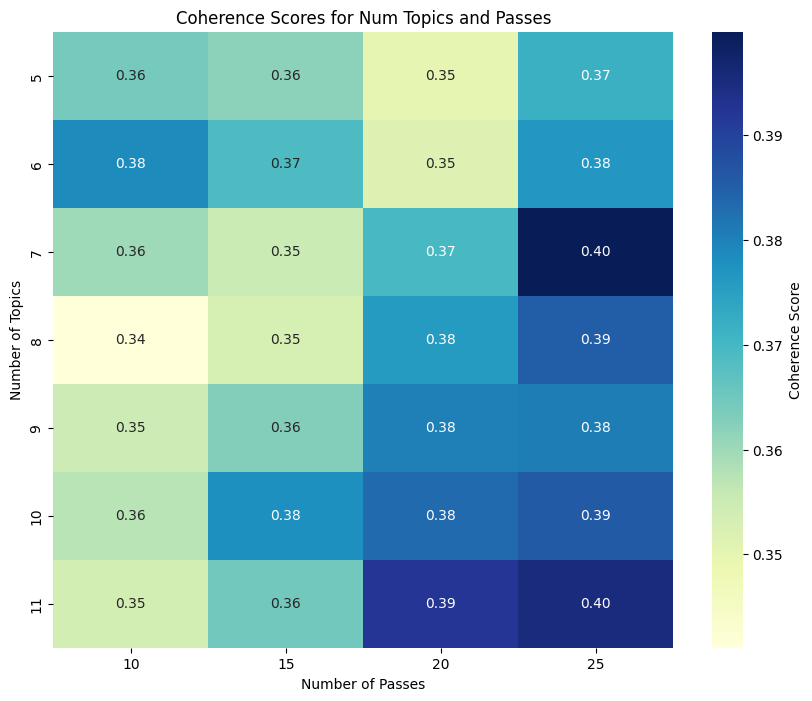

In [55]:
pivot_table = results_df.pivot(index='num_topics', columns='passes', values='coherence_score')
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Coherence Score'})
plt.title("Coherence Scores for Num Topics and Passes")
plt.xlabel("Number of Passes")
plt.ylabel("Number of Topics")
plt.show()


Again, we can see that the higher the number of passes and topics, the higher the coherence of these topics is. We also observe that no matter the number of topics, a higher number of passes will allow for a higher coherence score.
However, the absolute imporvement here is marginal, with the minimum coherence being 0.33 and the maximum 0.40, making it improve by only 0.07.
The small absolute difference suggests that the model's coherence does not strongly depend on the specific values of num_topics and passes within the tested ranges, making the coherence a rather robust evaluation method. It might also indicate that the dataset has inherent limitations in capturing more coherent topics.

However, topic modeling is an exploratory process and the evaluation should not solely rely on quantitative metrics. A combination of quantitative measures and qualitative assessment is crucial to ensure that the generated topics are meaningful and align with the domain knowledge or application requirements.  \
Moreover, recent research shows that quantitative metrics such as coherence score, are unreliable for topic model evaluation, partly because the concept of interpretability is ambiguous — what makes a model and its results interpretable?
Moreover, automated metrics designed for older systems may not work well with newer ones, and many experiments lack transparency, making it hard to generalize evaluation methods to different datasets or contexts. Emerging research uses AI, notably LLMs, to design and assess LDA models for specific goals showing promise but requiring further investigation.

----------

### CONCLUSION

This project explored the application of topic modeling and sentiment analysis to analyze gender differences in central bank speeches. Using both LDA and NMF models, we identified key themes such as monetary policy, banking supervision, and inflation. The topic distributions across genders suggested that men tend to focus more on the fiscality of the European Union and interest rates, and women on banking supervision and broader themes like inflation and climate. However, these distinctions were very subtle, suggesting shared priorities across genders in central banking discourse. Moreover, the difference in sample size for men and women raises concerns about the statistical validity of our study.

Sentiment analysis highlighted a wider emotional variability in men's speeches, with higher medians for both negative and positive sentiments. This may reflect a more assertive or emotionally charged tone, emphasizing both challenges and solutions more explicitly. While these insights are interetsing, limitations in processing long texts impacted the reliability of the sentiment classification.

The evaluation of topic coherence revealed marginal improvements with the number of topics and passes, but the small absolute differences highlighted the limitations of coherence as a definitive metric, which aligns with recent research questioning the reliability of traditional quantitative metrics and suggesting a need for more robust, interpretability-focused evaluation approaches.

Potential improvements include using LLMs to detect and interpret topics, as well as analyze sentiment more effectively in central bank speeches. We could also finetune a custom sentiment models, such as fine-tuned BERT, to improve sentiment analysis tailored to central bank language and longer texts.\
Expanding the dataset to include speeches from more central banks and speakers, particulalrly women, could offer deeper insights into global gendered discourse patterns. Finally, developing more advanced and personnalized evaluation methods beyond coherence scores would enhance the reliability and interpretability of topic modeling results.